In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from pprint import pformat

from hloc import extract_features, match_features, pairs_from_covisibility
from hloc import colmap_from_nvm, triangulation, localize_sfm, visualization

In [2]:
import argparse
import logging
from pathlib import Path
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import os
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from hloc.utils.read_write_model import read_model, read_images_binary

import alphashape
from shapely.geometry import Polygon

from PIL import Image, ImageDraw
from operator import itemgetter
import pickle
import h5py

from scipy import spatial
from shutil import copyfile
import random
import math

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline  

from scipy import spatial
from shutil import copyfile

In [3]:
# model = "/Volumes/MyPassport/aachen_v1_1/3D-models/aachen_v_1_1"
# box_dir="/Users/niziqian/repos/models/research/delf/delf/python/examples/sq_gopro_box_np"
# image_dir="/Volumes/MyPassport/aachen_v1_1/images_upright/"
# output_dir="/Users/niziqian/repos/models/research/delf/delf/python/examples/group"

# in container
model_dir = "/app/datasets/aachen_v1_1/3D-models/aachen_v_1_1"
image_dir = "/app/datasets/aachen_v1_1/images_upright"
box_dir="/app/mid_data/aachen_images_box/aachen_images"

output_dir="/app/output/"
mid_data_dir="/app/mid_data/"

logging.basicConfig(level=logging.DEBUG)
logging.getLogger('PIL').setLevel(logging.WARNING)

In [4]:
! ls /app/datasets/aachen_v1_1/3D-models/aachen_v_1_1

aachen_v_1_1.nvm  database_intrinsics_v1_1.txt	points3D.bin
cameras.bin	  images.bin			project.ini


In [5]:
logging.info('Reading the COLMAP model...')
cameras, images, points3D = read_model(model_dir)
logging.info('finished reading the COLMAP model')

[01/16/2022 23:19:38 INFO] Reading the COLMAP model...
[01/16/2022 23:21:13 INFO] finished reading the COLMAP model


In [6]:
def draw_points(image_path, points):
    image = mpimg.imread(image_path)
    print(image.shape[0])
    plt.imshow(image)
    plt.scatter(points[:, 0]*image.shape[1], points[:, 1]*image.shape[0], marker="x", color="red", s=2)
    plt.show()

1063


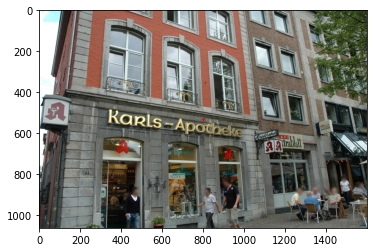

In [7]:
filename = image_dir + "/db/1.jpg"
pts = np.array([[0.5, 0.5]])
draw_points(filename, pts)

In [51]:
from hloc.patch_utils import box_preprocess, PatchSet, Patch, test_generate_patches, database_generate_patches, co_vis_grouping

In [52]:
# validation set spliting

print("total database image number:", len(images))

def validation_set_split(mid_data_dir, images):
    valid_path = mid_data_dir+"valid_images_id.pkl"
    if os.path.exists(valid_path):
        print("using exist valid set")
        with open(valid_path, "rb") as f:
            valid_images_id = pickle.load(f)
    else:
        print("generating new valid set")
        valid_images_id = set(random.sample(list(images.keys()), k = math.floor(0.1*len(images))))
        with open(valid_path, "wb") as f:
            pickle.dump(valid_images_id, f)

    print("validation set size:", len(valid_images_id))
    train_images_id = list(set(images.keys()).difference(set(valid_images_id)))
    print("training set size:", len(train_images_id))
    
validation_set_split(mid_data_dir, images)

total database image number: 6697
using exist valid set
validation set size: 669
training set size: 6028


In [10]:
from hloc.utils.parsers import parse_image_list

query_images = parse_image_list(Path("/app/datasets/aachen_v1_1/queries/day_time_queries_with_intrinsics.txt"), True)
query_images += parse_image_list(Path("/app/datasets/aachen_v1_1/queries/night_time_queries_with_intrinsics.txt"), True)
print("#query_images:", len(query_images))

[01/16/2022 23:23:28 INFO] Imported 824 images from day_time_queries_with_intrinsics.txt
[01/16/2022 23:23:28 INFO] Imported 191 images from night_time_queries_with_intrinsics.txt
#query_images: 1015


In [15]:
test_patch_list, test_image2patch = test_generate_patches(query_images, False)

 94%|█████████▍| 958/1015 [00:03<00:00, 297.81it/s]

[01/16/2022 23:24:20 WARNING] no object detected for /app/mid_data/aachen_images_box/aachen_images/query/night/nexus5x_additional_night/IMG_20170702_004435.npy


100%|██████████| 1015/1015 [00:03<00:00, 278.48it/s]

number of patches: 1223


In [23]:
patch_list, image2patch = database_generate_patches(images)

 16%|█▌        | 1039/6697 [14:03<1:06:56,  1.41it/s]

[01/16/2022 14:27:04 WARNING] no object detected for /app/mid_data/aachen_images_box/aachen_images/sequences/nexus4_sequences/sequence_1/aachen_nexus4_seq1_0072.npy


 22%|██▏       | 1499/6697 [21:26<1:10:56,  1.22it/s]

[01/16/2022 14:34:27 WARNING] no object detected for /app/mid_data/aachen_images_box/aachen_images/sequences/nexus4_sequences/sequence_1/aachen_nexus4_seq1_0073.npy


 29%|██▉       | 1968/6697 [28:27<51:09,  1.54it/s]  

[01/16/2022 14:41:28 WARNING] no object detected for /app/mid_data/aachen_images_box/aachen_images/sequences/nexus4_sequences/sequence_1/aachen_nexus4_seq1_0074.npy


 38%|███▊      | 2552/6697 [33:56<39:15,  1.76it/s]  

[01/16/2022 14:46:57 WARNING] no object detected for /app/mid_data/aachen_images_box/aachen_images/db/3312.npy


 39%|███▉      | 2643/6697 [34:53<30:37,  2.21it/s]  

[01/16/2022 14:47:53 WARNING] no object detected for /app/mid_data/aachen_images_box/aachen_images/db/3083.npy


 48%|████▊     | 3248/6697 [40:04<34:56,  1.64it/s]  /usr/local/lib/python3.6/dist-packages/shapely/ops.py:42: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  source = iter(source)
100%|██████████| 6697/6697 [1:20:30<00:00,  1.39it/s]

number of patches: 8633


In [24]:
invalid_list = list()
for i in range(len(patch_list)):
    if patch_list[i].validaty == False:
        invalid_list.append(i)
        
print("#invalid patches:" ,len(invalid_list))

#invalid patches: 1288


In [69]:
patch_set = co_vis_grouping(patch_list, do_crop=True, group_output_dir = '/app/mid_data/group1', images=images)

100%|██████████| 8633/8633 [3:29:06<00:00,  1.45s/it]   

[01/14/2022 15:20:31 INFO] Cropping...



100%|██████████| 8633/8633 [1:08:24<00:00,  2.10it/s]


In [25]:
# patchSet recover
patch_set = PatchSet()
for i in range(8633):
    patch_set.fa.append(i)
    
group_output_dir = '/app/mid_data/group1'
for group in tqdm(os.listdir(group_output_dir)):
    if group[0] == '.':
        continue
    group_id = int(group)
    for patch_name in os.listdir(os.path.join(group_output_dir, group)):
        patch_id=int(patch_name.split('.')[0])
        patch_set.fa[patch_id] = group_id

100%|██████████| 2776/2776 [00:08<00:00, 341.34it/s]


In [26]:
# validation set gt grouping
val_patch_set = list()
group_gt = dict()
for image_id in valid_images_id:
    patches = image2patch[image_id]
    for patch in patches:
        group_gt[patch] = patch_set.fa[patch]
        val_patch_set.append(patch)

In [27]:
with open(mid_data_dir+"patch_set.pkl", "wb") as f:
    pickle.dump(patch_set,f)
with open(mid_data_dir+"image2patch.pkl", "wb") as f:
    pickle.dump(image2patch,f)
with open(mid_data_dir+"group_gt.pkl", "wb") as f:
    pickle.dump(group_gt,f)   
with open(mid_data_dir+"val_patch_set.pkl", "wb") as f:
    pickle.dump(val_patch_set,f)   
    
# for patch in tqdm(patch_list):
#     patch.p2d_xys.clear()
# with open(mid_data_dir+"patch_list.pkl", "wb") as f:
#     pickle.dump(patch_list,f)

In [32]:
with open(mid_data_dir+"patch_set.pkl", "rb") as f:
    patch_set = pickle.load(f)
with open(mid_data_dir+"image2patch.pkl", "rb") as f:
    image2patch = pickle.load(f)
with open(mid_data_dir+"group_gt.pkl", "rb") as f:
    group_gt = pickle.load(f)   
with open(mid_data_dir+"val_patch_set.pkl", "rb") as f:
    val_patch_set = pickle.load(f)   

In [31]:
# load feature swap model
new_model_dir='/app/outputs/aachen/sfm_superpoint+superglue/'
logging.info('Reading the COLMAP model...')
cameras_new, images_new, points3D_new = read_model(new_model_dir)
logging.info('finished reading the COLMAP model')

[01/16/2022 23:29:48 INFO] Reading the COLMAP model...
[01/16/2022 23:30:26 INFO] finished reading the COLMAP model


In [34]:
# group binding
groups_patch_points=defaultdict(set) # for retrieval result examine
groups_image_points=defaultdict(set) # for localization 

for image_id, image in tqdm(images_new.items()):
    patches = image2patch[image_id]
    p3d_id_set = set(image.point3D_ids)
    for patch_id in patches:
        group_id = patch_set.find(patch_id)
        groups_image_points[group_id] = groups_image_points[group_id].union(p3d_id_set) 
#         if patch_id not in val_patch_set:
#             groups_patch_points[group_id] = groups_patch_points[group_id].union(patch_list[patch_id].p3d_ids)         

100%|██████████| 6697/6697 [00:04<00:00, 1430.08it/s]


In [35]:
with open(mid_data_dir+"groups_patch_points.pkl", "wb") as f:
    pickle.dump(groups_patch_points,f)
with open(mid_data_dir+"groups_image_points.pkl", "wb") as f:
    pickle.dump(groups_image_points,f)

In [110]:
# database & query patch descriptor generation
feature_path = extract_features.main(extract_features.confs['netvlad'], Path('/app/mid_data/test'), Path("/app/outpu/"))
print(feature_path)

[01/16/2022 18:16:02 INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[01/16/2022 18:16:02 INFO] Found 1223 images in root /app/mid_data/test.


100%|██████████| 1223/1223 [42:32<00:00,  2.09s/it]

[01/16/2022 18:58:48 INFO] Finished exporting features.


/app/outpu/global-feats-netvlad.h5


In [20]:
# generate mean descriptors for groups

# db_feature_path = "/app/mid_data/descriptors/global-feats-netvlad_db.h5"
db_feature_path = "/app/output/global-feats-netvlad.h5"
# db_feature_path = "/app/mid_data/descriptors/db_descriptors_25epoch_raw.h5"

db_desc = h5py.File(db_feature_path, 'r')

class_list =[]
database = []
index = 0
val_desc = dict()

for group in tqdm(db_desc.keys()):
    group_desc = []
    for ele in db_desc[group].keys():
        patch_id = int(ele.split('.')[0])
#         if patch_id in val_patch_set:
#             val_desc[patch_id]=np.array(db_desc[group][ele]['global_descriptor'])#.flatten()
#         else:   
        group_desc.append(np.array(db_desc[group][ele]['global_descriptor']))#.flatten())
        
    if len(group_desc) > 0:
        group_desc = np.array(group_desc)
#         print(np.mean(group_desc, axis=0).shape)
        database.append(np.mean(group_desc, axis=0))
        class_list.append(group)
database=np.array(database)
print(database.shape)
tree = spatial.KDTree(database)

100%|██████████| 2775/2775 [00:05<00:00, 473.50it/s]


(2775, 4096)


In [21]:
def group_retrival(test_desc, tree, k = 5, gt = None):
    gt_posi = dict()
    ave_posi = 0
    recall = 0
    retrieve_groups = dict()
    for patch_id in tqdm(test_desc.keys()):
        d, group_indices = tree.query(test_desc[patch_id], k)
        group_ids = [int(class_list[i]) for i in group_indices]
        retrieve_groups[patch_id] = group_ids
#         print(patch_id, group_ids, gt[patch_id])
        if not gt == None:  
            for i in range(k):
                gt_posi[patch_id] = -1
                if (group_ids[i] == gt[patch_id] or 
                    len(patch_list[patch_id].p3d_ids.intersection(groups_patch_points[group_ids[i]])) > 50):
                    gt_posi[patch_id] = i
                    ave_posi += i+1
                    recall += 1
                    break
                    
    if not gt == None:
        # report
        print("recall:", recall/len(gt))
        print("ave. Posi:", ave_posi/recall)
        
    return retrieve_groups

In [22]:
retrieve_groups = group_retrival(val_desc, tree, k=5, gt=group_gt)

NameError: name 'group_gt' is not defined

In [23]:
test_desc = dict()
test_feature_path = "/app/outpu/global-feats-netvlad.h5"
test_desc_file = h5py.File(test_feature_path, 'r')
for ele in tqdm(test_desc_file.keys()):
    patch_id = int(ele.split('.')[0])
    test_desc[patch_id]=np.array(test_desc_file[ele]['global_descriptor'])
    
test_retrieve_groups = group_retrival(test_desc, tree, k=5)

100%|██████████| 1223/1223 [01:22<00:00, 14.77it/s]


In [48]:
print(points3D[1034796])
points3D[1034796].image_ids
points3D[1034796].point2D_idxs
image_path=images[1251].name
f = h5py.File('/app/outputs/aachen/feats-sift.h5', 'r')
# image_obj = f
# for level in image_path:
#     image_obj = image_obj[level]
# print(image_obj['descriptors'][:,0])
print(f[image_path])
print(cameras[images[1486].camera_id])
f.close()


Point3D(id=1034796, xyz=array([769.607 ,  14.6241,  19.7262]), rgb=array([64, 57, 51]), error=array(0.345278), image_ids=array([1251, 1223, 1222, 1218]), point2D_idxs=array([ 333, 3358,  630,   96]))
<HDF5 group "/db/2123.jpg" (4 members)>
Camera(id=1486, model='SIMPLE_RADIAL', width=1067, height=1600, params=array([ 1.34261e+03,  5.33500e+02,  8.00000e+02, -7.89248e-02]))


In [36]:
with open(mid_data_dir+"groups_image_points.pkl", "rb") as fd:
    groups_image_points = pickle.load(fd)


In [49]:
#localize!
import cv2
import pycolmap
import time

f = h5py.File('/app/outputs/aachen/feats-sift.h5', 'r')

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

point_desc_file = h5py.File('/app/mid_data/point_descs.h5', 'a')

# point_desc = dict()
# result = dict()
max_inlier_nums = dict()
# def localize(image):
for query_image in tqdm(query_images):
    file_name, param = query_image
#     print(file_name)
    image_name = file_name.split('/')[-1]
    if image_name in result:
        continue
    candidate_point_set = list()
    patch_ids = test_image2patch[image_name]
    
    # point set merging
    for patch_id in patch_ids:
        groups = test_retrieve_groups[patch_id]
        
        for group_id in groups:
            merged_flag = False
            for i in range(len(candidate_point_set)):
#                 print(len(groups_image_points[group_id]))
                if len(candidate_point_set[i].intersection(groups_image_points[group_id])) > 100:
                    merged_flag = True
                    candidate_point_set[i] = candidate_point_set[i].union(groups_image_points[group_id])
                    break
            if not merged_flag:
#                 print(len(groups_image_points[group_id]))
                candidate_point_set.append(groups_image_points[group_id])

#     print("# candidate_point_set: ", len(candidate_point_set))
    
    max_inlier_num = 0
    final_qvec = np.array([-0.02718695,-0.12122045,0.20194369,0.97148609])
    final_tvec = np.array([723.98874206,76.41164933,187.85558868])
    
    # fusion & matching
    for cps in candidate_point_set:
        p3d_descs = list()
        p3d_ids = list()
#         print(len(cps))
        for p3d_id in cps:
            if p3d_id == -1:
                continue
            p3d_ids.append(p3d_id)
            sid = str(p3d_id)
            if sid not in point_desc_file:
                p3d=points3D_new[p3d_id]
                desc = f[images_new[p3d.image_ids[0]].name]['descriptors'][:,p3d.point2D_idxs[0]]
                point_desc_file.create_dataset(sid, data=desc)
#                 print(sid)
            p3d_descs.append(point_desc_file[sid])
            
        p3d_descs = np.array(p3d_descs)
#         print(p3d_descs.shape)
        tree = spatial.KDTree(p3d_descs)
        
        p2d_descs = f[file_name]['descriptors'].__array__().transpose()
        
        matches = flann.knnMatch(p2d_descs, p3d_descs, k=2)
                     
#         print(len(matches))
        mp3d = list()
        mkpq = list()
        for i,(m,n) in enumerate(matches):
            if m.distance < 0.7*n.distance:
                mp3d.append(points3D_new[p3d_ids[m.trainIdx]].xyz)
                mkpq.append(f[file_name]['keypoints'][m.queryIdx])
                
        mp3d = np.array(mp3d).reshape(-1, 3)
        mkpq = np.array(mkpq).reshape(-1, 2)
        mkpq += 0.5
            
#         camera = cameras_new[images[val_image_id].camera_id]
        cfg = {
            'model': param[0],
            'width': param[1],
            'height': param[2],
            'params': param[3],
        }
        ret = pycolmap.absolute_pose_estimation(mkpq, mp3d, cfg)
        if ret['success'] == True:
#             print(ret['num_inliers'], ret['qvec'], ret['tvec'])
            if ret['num_inliers'] > max_inlier_num:
                max_inlier_num = ret['num_inliers']
                final_qvec = ret['qvec']
                final_tvec = ret['tvec']
#     print(max_inlier_num, final_qvec, final_tvec)
    result[image_name] = (final_qvec, final_tvec)
    max_inlier_nums[image_name] = max_inlier_num
    
f.close()
point_desc_file.close()

100%|██████████| 1015/1015 [4:27:19<00:00, 15.80s/it]  


In [50]:
with open("Aachen_v1_1_eval_PRhloc.txt", "w+") as f:
    for name, res in tqdm(result.items()):
        f.write(' '.join([name, str(res[0][0]), str(res[0][1]),  str(res[0][2]), str(res[0][3]), 
                          str(res[1][0]),str(res[1][1]),str(res[1][2])]) + '\n')

100%|██████████| 1015/1015 [00:00<00:00, 14803.49it/s]


In [125]:
np.savez("test.npz", mp3d=mp3d, mkpq=mkpq)
mp3d = np.load("test.npz")['mp3d']
mkpq = np.load("test.npz")['mkpq']
camera = cameras_new[6]
cfg = {
    'model': camera.model,
    'width': camera.width,
    'height': camera.height,
    'params': camera.params,
}
ret = pycolmap.absolute_pose_estimation(mkpq, mp3d, cfg)
print(ret)
print(ret['num_inliers'], ret['qvec'], ret['tvec'])
print(images_new[6].qvec, images_new[6].tvec)


{'success': False}


KeyError: 'num_inliers'

In [ ]:
localize_sfm.main(
    reference_sfm,
    Path("/app/mid_data/day_time_queries_with_intrinsics.txt"),
    loc_pairs, # retrieval
    feature_path, # features
    loc_match_path, # matches
    results,
    covisibility_clustering=False)  # not required with SuperPoint+SuperGlue

In [88]:
# test image patch process
day_test_file = "/app/mid_data/day_time_queries_with_intrinsics.txt"
test_image_name_list = []
test_image_w_list = []
test_image_h_list = []

test_patch_list = list()
test_image_patch = dict()
cnt=0
with open(test_file, "r") as f:
    lines = f.readlines()
    for line in lines:
        test_image_name_list.append(line.split(' ')[0])
        test_image_w_list.append(int(line.split(' ')[2]))
        test_image_h_list.append(int(line.split(' ')[3]))

for i in tqdm(range(len(test_image_name_list))):
    image_name = test_image_name_list[i]
    w = test_image_w_list[i]
    h = test_image_h_list[i]
    
    box_file_name = image_name.split('.')[0] + ".npy"
    
    test_image_patch[image_name] = list()

    if os.path.exists(os.path.join(box_dir, box_file_name)):
#         print(os.path.join(box_dir, box_file_name))
        
        data = np.load(os.path.join(box_dir, box_file_name))
        data = box_preprocess(data, w, h)
        for box_id in range(data.shape[0]):
#             print(data[box_id])
            test_patch_list.append(patch(data[box_id], image_name, cnt))
            test_image_patch[image_name].append(cnt)
            cnt += 1
       
print(len(test_patch_list))

# output groups
group_output_dir = os.path.join(mid_data_dir , "test")
for i in tqdm(range(len(test_patch_list))):
    image_path = os.path.join(image_dir, test_patch_list[i].image_id)
    save_path = os.path.join(group_output_dir, str(i)+ ".png")
    test_patch_list[i].save_crop(image_path, save_path)
    
    
# with open(mid_data_dir+"test_patch_set.pkl", "wb") as f:
#     pickle.dump(test_patch_set,f)
with open(mid_data_dir+"test_image_patch.pkl", "wb") as f:
    pickle.dump(test_image_patch,f)

100%|██████████| 824/824 [00:03<00:00, 259.73it/s]


749


100%|██████████| 749/749 [06:01<00:00,  2.07it/s]


In [107]:
feature_path = extract_features.main(extract_features.confs['netvlad'], Path(group_output_dir), Path("/app/output/"))
# feature_path = extract_features.main(extract_features.confs['netvlad'], Path('/app/mid_data/sample'), Path("/app/output/"))

[01/06/2022 18:41:16 INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[01/06/2022 18:41:16 INFO] Found 2 images in root /app/mid_data/sample.


  0%|          | 0/2 [00:00<?, ?it/s]

['1.png'] torch.Size([1, 3, 1024, 798])
torch.Size([1, 3, 1024, 798])
torch.Size([1, 3, 1024, 798])


 50%|█████     | 1/2 [00:04<00:04,  4.47s/it]

['3.png'] torch.Size([1, 3, 547, 1024])
torch.Size([1, 3, 547, 1024])
torch.Size([1, 3, 547, 1024])


100%|██████████| 2/2 [00:06<00:00,  3.49s/it]

[01/06/2022 18:41:38 INFO] Finished exporting features.


In [193]:
features = h5py.File('/app/pytorch-NetVlad/sample_descriptors_1.h5', 'r')
# keys = list(features['descriptors'])
print(features.keys())

dist = np.linalg.norm(np.array(features['1']['1.png']['descriptors'])-
                      np.array(features['1']['1_1.png']['descriptors']))
print(dist)
dist = np.linalg.norm(np.array(features['1']['1.png']['descriptors'])-
                      np.array(features['1']['2.png']['descriptors']))
print(dist)
dist = np.linalg.norm(np.array(features['1']['1.png']['descriptors'])-
                      np.array(features['1']['769.png']['descriptors']))
print(dist)
dist = np.linalg.norm(np.array(features['1']['2.png']['descriptors'])-
                      np.array(features['1']['769.png']['descriptors']))
print(dist)
dist = np.linalg.norm(np.array(features['1']['1.png']['descriptors'])-
                      np.array(features['2']['743.png']['descriptors']))
print(dist)

dist = np.linalg.norm(np.array(features['1']['769.png']['descriptors'])-
                      np.array(features['2']['743.png']['descriptors']))
print(dist)
features.close()

<KeysViewHDF5 ['1', '2']>
0.0
0.56299794
0.6751916
0.7107402
1.067283
0.9400011


In [62]:
feature_path

PosixPath('/app/output/global-feats-netvlad.h5')

In [74]:
db_feature_path = "/app/mid_data/global-feats-netvlad_db.h5"
q_feature_path = "/app/mid_data/global-feats-netvlad_q.h5"

class_list =[]
database = []
db_feature = h5py.File(db_feature_path, 'r')
q_feature = h5py.File(q_feature_path, 'r')

In [75]:
# print(db_feature.keys())
print(db_feature['0'].keys())

<KeysViewHDF5 ['0.png', '36.png']>


In [89]:
# database building
db_desc = list()
db_name_ind = list()

for group in tqdm(db_feature.keys()):
    for ele in db_feature[group].keys():
        db_desc.append(np.array(db_feature[group][ele]['global_descriptor']))
        db_name_ind.append(ele)
db_desc = np.array(db_desc)
print(db_desc.shape)

tree = spatial.KDTree(db_desc)        

100%|██████████| 3407/3407 [00:15<00:00, 222.75it/s]


(5933, 4096)


In [72]:
invalid_num = 0
for i in failed_cases:
    if val_patch_list[i].validaty == False:
        invalid_num += 1
#         print(i)
print(invalid_num/len(failed_cases))

invalid_num1 = 0
for i in suc_cases:
    if val_patch_list[i].validaty == False:
        invalid_num1 += 1
print(invalid_num1/len(suc_cases))

print(invalid_num, invalid_num1, invalid_num/ (invalid_num1 + invalid_num))

0.8142857142857143
0.07759699624530664
57 62 0.4789915966386555


In [90]:
retrieval_result = dict()
max_dist = 0
for image_name in tqdm(q_feature.keys()):
    if '.' in image_name:
        retrieval_result[image_name] = list()
        decs = np.array(q_feature[image_name]['global_descriptor'])
        dists, indexs = tree.query(decs, k = 50)
        if dists[-1] > max_dist:
            max_dist = dists[-1]
        for i in range(50):
            retrieval_result[image_name].append((db_name_ind[indexs[i]], dists[i]))
    
print(max_dist)

100%|██████████| 1319/1319 [02:07<00:00, 10.31it/s]

1.376549080367633


In [91]:
with open(mid_data_dir+"image_patch.pkl", "rb") as f:
    image_patch = pickle.load(f)
    
patch_image_name_dict = dict()
for image_id, patch_index_list in image_patch.items():
    for db_patch_ind in patch_index_list:
        patch_image_name_dict[db_patch_ind] = image_id

In [48]:
# validation set

# val_feature_path = "/app/mid_data/descriptors/global-feats-netvlad_val.h5"
# val_feature_path = "/app/pytorch-NetVlad/q_descriptors.h5"
val_feature_path = "/app/mid_data/descriptors/q_descriptors_25epoch_raw.h5"
val_desc = h5py.File(val_feature_path, 'r')

k = 5
best_retrieval_posi = list()
best_retrieval_covis = list()
for ele in sorted(val_desc.keys(), key=lambda x:int(x.split('.')[0])):
    decs = np.array(np.array(val_desc[ele]['descriptors']).flatten())
    
    d, group_indices = tree.query(decs, k)
    max_ind = -1
    best_group = -1
    max_intersection = 0
    patch_ind = int(ele.split('.')[0])
    for i in range(k):
        group_id = int(class_list[group_indices[i]])
        cur_inters = len(val_patch_list[patch_ind].p3d_ids.intersection(groups_points[group_id]))
        if cur_inters > max_intersection:
            max_ind = i+1
            best_group = group_id
            max_intersection = cur_inters
    print(patch_ind, best_group, max_ind, max_intersection)
    best_retrieval_posi.append(max_ind)
    best_retrieval_covis.append(max_intersection)

0 467 1 4277
1 453 5 1897
2 467 1 4404
3 1225 5 123
4 13 1 2934
5 300 1 4147
6 389 1 105
7 4868 2 540
8 42 1 344
9 42 2 1020
10 44 1 3482
11 -1 -1 0
12 5 1 4832
13 1806 1 1166
14 136 2 1650
15 5675 1 594
16 462 1 46
17 677 1 367
18 102 1 1413
19 -1 -1 0
20 -1 -1 0
21 462 3 62
22 677 1 504
23 95 5 1117
24 13 1 4715
25 11 1 6599
26 315 1 856
27 44 1 3266
28 131 1 2339
29 91 1 2069
30 15 1 6435
31 290 1 1091
32 227 4 412
33 1152 2 417
34 44 1 4109
35 95 2 261
36 240 1 2223
37 201 1 2090
38 274 1 2105
39 1127 1 3990
40 57 1 4379
41 143 1 5066
42 29 1 3282
43 58 1 5676
44 -1 -1 0
45 14 4 4088
46 14 1 2888
47 91 2 3653
48 381 1 1210
49 558 5 526
50 274 2 201
51 14 2 3585
52 4851 1 832
53 845 2 916
54 4312 1 537
55 510 2 411
56 392 1 5141
57 -1 -1 0
58 13 3 1
59 14 1 3446
60 91 1 1810
61 528 1 2428
62 41 1 3029
63 2 4 155
64 4227 2 173
65 136 3 2604
66 92 1 1878
67 361 1 1023
68 976 1 2996
69 13 2 5575
70 1956 1 361
71 13 1 5196
72 78 1 1801
73 442 1 4549
74 674 3 39
75 161 2 520
76 87 1 5180

564 3090 1 877
565 1337 2 716
566 85 1 2195
567 264 1 3178
568 2363 1 138
569 50 3 1615
570 4233 3 64
571 4138 1 713
572 1781 1 922
573 3 5 1598
574 4144 1 1079
575 4138 1 1042
576 3 4 2750
577 1784 1 663
578 -1 -1 0
579 20 1 4667
580 20 2 3868
581 4169 1 1302
582 4169 1 1130
583 4180 1 785
584 50 2 3901
585 877 2 122
586 706 5 1474
587 347 1 1376
588 110 1 1397
589 4211 1 1870
590 3729 1 640
591 3847 2 524
592 143 3 4005
593 143 3 3281
594 30 1 1467
595 610 2 2870
596 610 3 2510
597 2468 3 783
598 4284 1 308
599 845 3 816
600 3171 1 377
601 231 1 5125
602 1956 1 754
603 227 1 2952
604 2686 1 77
605 2625 1 253
606 32 3 555
607 2826 4 235
608 4501 1 294
609 1190 1 500
610 3039 2 631
611 2345 5 20
612 2954 4 236
613 -1 -1 0
614 1956 1 826
615 2549 1 428
616 4457 2 308
617 -1 -1 0
618 78 1 3066
619 -1 -1 0
620 4081 1 1125
621 4081 1 991
622 2291 1 517
623 2255 2 369
624 4102 1 117
625 3452 1 582
626 4343 2 102
627 2162 1 1706
628 79 1 3454
629 20 1 4302
630 -1 -1 0
631 5 2 839
632 896 1 3

In [128]:
print(len(gt_result), len(my_result))

results = list()
for k in range(1, 50):
    match_cnt = list()
    for query_name, result in my_result.items():
        cnt = 0
        my_set = set(result[:k])
        gt_set = set(gt_result[query_name][:k])
        cnt += len(my_set.intersection(gt_set))
        match_cnt.append(cnt/k)
        
    results.append(np.mean(np.array(match_cnt))

plt.plot(list(range(1, 50)), results)
print(np.mean(np.array(match_cnt)), np.min(np.array(match_cnt)), np.max(np.array(match_cnt)))

SyntaxError: invalid syntax (<ipython-input-128-451c82a08754>, line 16)

In [ ]:
index = 0
for group in q_feature.keys():
    if group[0] == 't':
        continue
    group_desc = []
    for ele in f[group].keys():
        group_desc.append(np.array(f[group][ele]['global_descriptor']))
        
    group_desc = np.array(group_desc)
#     print(group_desc.shape)
#     print(group, np.mean(group_desc, axis=0), np.std(group_desc, axis=0))
    database.append(np.mean(group_desc, axis=0))
    class_list.append(group)

In [ ]:
for ele in f['test'].keys():
    decs = np.array(f[group][ele]['global_descriptor'])
    d, i = tree.query(decs, k = 2)
    
    print(ele, class_list[i[0]], d[0],  class_list[i[1]], d[1])

1696
6595 3.8908554572271385 122 1


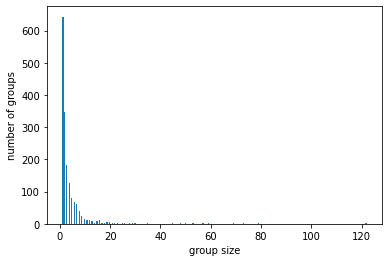

In [51]:
# groupping analysis
group_path = "/app/mid_data/group"
print(len(os.listdir(group_path)))
group_size=list()
for group in os.listdir(group_path):
    if group[0] == '.':
        continue
    group_size.append(len(os.listdir(os.path.join(group_path, group))))
    
plt.hist(group_size, bins='auto')
plt.xlabel("group size")
plt.ylabel("number of groups")
plt.show

group_size = np.array(group_size)
print(np.sum(group_size),  np.mean(group_size), np.max(group_size),  np.min(group_size))